# Transitions Demo

This notebook introduces you to Tal Yarkoni's `transitions` module, and much of this notebook
is taken from the excellent set of examples in [the github repository readme](https://github.com/pytransitions/transitions#diagrams) for the module.

This is very lightweight (unlike many graph and finite state packages) and installable with 
`conda install` or `pip install`.

## Using transitions

This demo is simply a notebook adapted from the [transitions Github README page.](https://github.com/pytransitions/transitions)  with afew small addons to support
language processing.

The has been updated for notebook display, by  extending the link to `graphviz.agraph` objects,
which uses the `to_graph()` method, to `graphviz.Source` objects which have `._repr_mimebundle_`
and know how to display themselves in a notebook.

## Example one:  sheep language (with punctuation!)

This beautifully minimal "language" is from Jurafsky and Martin  (*Speech and Language Processing*).

In [2]:
from transitions import MachineError

import random
import graphviz
try:
  import pygraphviz
  from transitions.extensions import GraphMachine as Machine
  pygraphviz_available = True
except ModuleNotFoundError:
  from transitions import Machine
  pygraphviz_available = False


class SheepLanguage(object):

    # Define some states. 
    # Start will be the init state.
    states = ['Start','b', 'a1', 'a2','End']
    accept = False
    source = None
    
    def __init__ (self):
        self.initialize()
        self.init_display()

    def initialize(self):


        # How many instance of the letter "a" have we seen?
        self.as_seen = 0

        # Initialize the state machine
        self.machine = Machine(model=self, states=SheepLanguage.states, initial='Start')

        # Add some transitions. We could also define these using a static list of
        # dictionaries, as we did with states above, and then pass the list to
        # the Machine initializer as the transitions= argument.

        # See b in start state
        self.machine.add_transition(trigger='b', source='Start', dest='b')

        # See first a in b state
        self.machine.add_transition('a', 'b', 'a1')

        # See second a in a1 state
        self.machine.add_transition('a', 'a1', 'a2')

        # See a in a2 state
        self.machine.add_transition('a','a2','a2')
        
        # See ! in a2 state
        self.machine.add_transition('!','a2','End', after='accept_string')

    def accept_string(self):
        """ Everything is good. """
        self.accept = True
        return self.accept
        
    def reject_string(self):
        """ Everything is bad. """
        self.accept = False
        return self.accept
        
    def consume_string (self, in_str):
        for c in in_str:
            try:
               getattr(self,c)()
            except MachineError:
               return self.reject_string()
        return self.accept
    
    def init_display(self):
        """
        Needs to be re-executed if the graph is altered.
        """
        if pygraphviz_available:
            self.source = graphviz.Source(self.get_graph().to_string())
            # This is the attribute tht contains self display info
            self._repr_mimebundle_ = self.source._repr_mimebundle_
            return None

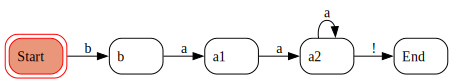

In [3]:
sl = SheepLanguage()
sl
# Uncomment this to get your sheep network drawn & saved as a file.
#sl.get_graph().draw('sheep_language.png', prog='dot')

In [4]:
sl.b()

True

In [5]:
sl.state

'b'

In [6]:
sl.b()

MachineError: "Can't trigger event b from state b!"

In [7]:
sl.a()

True

In [8]:
sl.accept

False

In [9]:
sl.a()

True

In [10]:
sl.accept

False

In [11]:
# sl.!()  is a Python syntax error, because '!' is not a legal 1st char for a name
getattr(sl,'!')()

True

In [12]:
sl.accept

True

In [13]:
getattr(sl,'!')()

MachineError: "Can't trigger event ! from state End!"

### Consuming strings

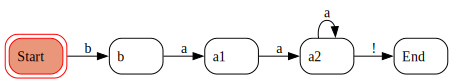

In [14]:
sl

In [15]:
sl = SheepLanguage()
sl.consume_string('baa!')

True

In [16]:
sl = SheepLanguage()
sl.consume_string('baaaa!')

True

In [17]:
sl = SheepLanguage()
sl.consume_string('ba!')

False

In [18]:
sl = SheepLanguage()
sl.consume_string('baa!a')

False

In [19]:
sl = SheepLanguage()
sl.consume_string('baa')

False

## Superhero state machine

Next a non-linguistic example.

In [20]:
from transitions import MachineError
import random
import graphviz

try:
  import pygraphviz
  from transitions.extensions import GraphMachine as Machine
  pygraphviz_available = True
except ModuleNotFoundError:
  from transitions import Machine
  pygraphviz_available = False


class NarcolepticSuperhero(object):

    # Define some states. Most of the time, narcoleptic superheroes are just like
    # everyone else. Except for...
    # asleep will be the init state.
    states = ['asleep', 'hanging out', 'hungry', 'sweaty', 'saving the world']
    
    def __init__ (self,name):
        self._initialize(name)
        self.init_display()

    def _initialize(self, name):

        # No anonymous superheroes on my watch! Every narcoleptic superhero gets
        # a name. Any name at all. SleepyMan. SlumberGirl. You get the idea.
        self.name = name

        # What have we accomplished today?
        self.kittens_rescued = 0

        # Initialize the state machine
        self.machine = Machine(model=self, states=NarcolepticSuperhero.states, initial='asleep')

        # Add some transitions. We could also define these using a static list of
        # dictionaries, as we did with states above, and then pass the list to
        # the Machine initializer as the transitions= argument.

        # At some point, every superhero must rise and shine.
        self.machine.add_transition(trigger='wake_up', source='asleep', dest='hanging out')

        # Superheroes need to keep in shape.
        self.machine.add_transition('work_out', 'hanging out', 'hungry')

        # Those calories won't replenish themselves!
        self.machine.add_transition('eat', 'hungry', 'hanging out')

        # Superheroes are always on call. ALWAYS. But they're not always
        # dressed in work-appropriate clothing.
        self.machine.add_transition('distress_call', '*', 'saving the world',
                         before='change_into_super_secret_costume')

        # When they get off work, they're all sweaty and disgusting. But before
        # they do anything else, they have to meticulously log their latest
        # escapades. Because the legal department says so.
        self.machine.add_transition('complete_mission', 'saving the world', 'sweaty',
                         after='update_journal')

        # Sweat is a disorder that can be remedied with water.
        # Unless you've had a particularly long day, in which case... bed time!
        self.machine.add_transition('clean_up', 'sweaty', 'asleep', conditions=['is_exhausted'])
        self.machine.add_transition('clean_up', 'sweaty', 'hanging out')

        # Our NarcolepticSuperhero can fall asleep at pretty much any time.
        self.machine.add_transition('nap', '*', 'asleep')

    def update_journal(self):
        """ Dear Diary, today I saved Mr. Whiskers. Again. """
        self.kittens_rescued += 1

    @property
    def is_exhausted(self):
        """ Basically a coin toss. """
        return random.random() < 0.5

    def change_into_super_secret_costume(self):
        print("Beauty, eh?")
        
    def init_display(self):
        """
        Needs to be re-exceuted if the graph is altered.
        """
        if pygraphviz_available:
            self.source = graphviz.Source(self.get_graph().to_string())
            self._repr_mimebundle_ = self.source._repr_mimebundle_
            return None

There, now you've baked a state machine into NarcolepticSuperhero. Let's take him/her/it out for a spin...

In [22]:
batman = NarcolepticSuperhero("Batman")
batman.state
'asleep'

'asleep'

In [24]:
batman.wake_up()
batman.state
'hanging out'

'hanging out'

In [25]:
batman.nap()
batman.state
'asleep'

'asleep'

In [26]:
batman.clean_up()
#MachineError: "Can't trigger event clean_up from state asleep!"

MachineError: "Can't trigger event clean_up from state asleep!"

In [27]:
batman.wake_up()
batman.work_out()
batman.state
#'hungry'

'hungry'

In [28]:
# Batman still hasn't done anything useful...
batman.kittens_rescued
#0

0

In [29]:
# We now take you live to the scene of a horrific kitten entreement...
batman.distress_call()
#'Beauty, eh?'

Beauty, eh?


True

In [30]:
batman.state
#'saving the world'

'saving the world'

In [31]:
# Back to the crib.
batman.complete_mission()
batman.state
#'sweaty'

'sweaty'

In [32]:
batman.clean_up()
batman.state
#'asleep'   # Too tired to shower!

'asleep'

In [33]:
# Another productive day, Alfred.
batman.kittens_rescued
#1

1

In [34]:
batman.is_exhausted

True

But what is batman really?

Note this will behave very differently if `pygraphviz` is not working  (and it won't be in a Colab
notebook).

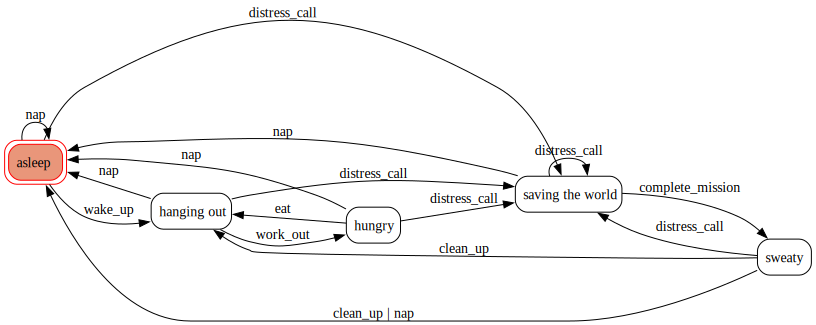

In [95]:
batman

While we cannot read the mind of the actual batman, we surely can visualize the current state of our NarcolepticSuperhero.

Have a look at the Diagrams extentions if you want to know how.

## Diagrams

The following simple version of outputting drawings (layouts) works on the Narcoleptic superhero.
But only if pygraphviz has been successfully installed.

If using this notebook in Jupyter on local machine, just flip back to the Home tab to check out the ".png" 
or ".pdf" file that will have been saved there.

In [25]:
from transitions.extensions import GraphMachine as Machine
#m = Model()
m = NarcolepticSuperhero("Robin")
# without further arguments pygraphviz will be used
#machine = Machine(model=m)
# when you want to use graphviz explicitely
#machine = Machine(model=m, use_pygraphviz=False, ...)
# in cases where auto transitions should be visible
#machine = Machine(model=m, show_auto_transitions=True, ...)

# draw the whole graph ... and save in a .png file.
m.get_graph().draw('robin_diagram2.png', prog='dot')
# ... or just the region of interest
# (previous state, active state and all reachable states)
#roi = m.get_graph(show_roi=True).draw('my_state_diagram.png', prog='dot')

In [27]:
g = m.get_graph()

In [24]:
print(g.draw.__doc__)

Output graph to path in specified format.

        An attempt will be made to guess the output format based on the file
        extension of `path`.  If that fails, then the `format` parameter will
        be used.

        Note, if `path` is a file object returned by a call to os.fdopen(),
        then the method for discovering the format will not work.  In such
        cases, one should explicitly set the `format` parameter; otherwise, it
        will default to 'dot'.

        If path is None, the result is returned as a Bytes object.

        Formats (not all may be available on every system depending on
        how Graphviz was built)

            'canon', 'cmap', 'cmapx', 'cmapx_np', 'dia', 'dot',
            'fig', 'gd', 'gd2', 'gif', 'hpgl', 'imap', 'imap_np',
            'ismap', 'jpe', 'jpeg', 'jpg', 'mif', 'mp', 'pcl', 'pdf',
            'pic', 'plain', 'plain-ext', 'png', 'ps', 'ps2', 'svg',
            'svgz', 'vml', 'vmlz', 'vrml', 'vtx', 'wbmp', 'xdot', 'xlib'


       

In [26]:
# create dot file from graph
#g.draw("robin_diagram2.dot", format="dot", prog="dot")

In [73]:
# Create string contents of dot file.  Note: this has layout info.
print(g.to_string())

strict digraph "" {
	graph [bb="0,0,218.86,117.62",
		rankdir=LR
	];
	node [color=black,
		fillcolor=white,
		label="\N",
		peripheries=1,
		shape=rectangle,
		style="rounded,filled"
	];
	edge [color=black];
	asleep	[color=red,
		fillcolor=darksalmon,
		height=0.72222,
		label="asleep\l",
		peripheries=2,
		pos="41.646,50.888",
		width=0.97222];
	asleep -> asleep	[label=nap,
		lp="104.4,50.888",
		pos="e,76.814,44.164 76.814,57.612 86.882,57.348 94.646,55.107 94.646,50.888 94.646,48.449 92.051,46.671 87.916,45.554"];
	"hanging out"	[height=0.5,
		label="hanging out\l",
		pos="123.54,45.875",
		width=1.1181];
	asleep -> "hanging out"	[label=wake_up,
		lp="101.35,63.673",
		pos="e,82.848,55.129 76.786,55.43 76.912,55.425 77.037,55.42 77.163,55.415"];
	"saving the world"	[height=0.5,
		label="saving the world\l",
		pos="80.731,18",
		width=1.4826];
	asleep -> "saving the world"	[label=distress_call,
		lp="110.47,19.783",
		pos="e,77.341,27.723 77.016,28.137 77.071,28.067 77.125,27.998 77.

##  From dot file to graphviz source

In [35]:
import graphviz
g22 = graphviz.Source.from_file("robin_diagram2.dot")

Graphviz source isn't really a graph.  It's an api for graph rendering.

In [43]:
for att in "filename engine format graph_attr node_attr edge_attr render renderer".split():
    try:
        print(getattr(g22,att))
    except:
        print (f"{att} undefined!")
        continue

robin_diagram2.dot
dot
pdf
graph_attr undefined!
node_attr undefined!
edge_attr undefined!
<bound method Render.render of <graphviz.sources.Source object at 0x1105212b0>>
None


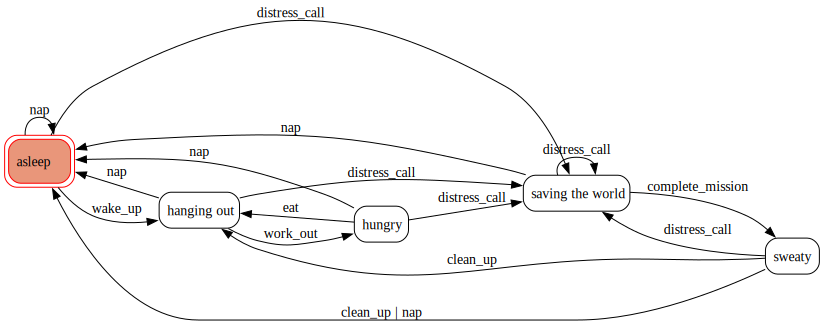

In [36]:
g22

# The non-quickstart

## Basic initialization

Getting a state machine up and running is pretty simple. Let's say you have the object lump (an instance of class Matter), and you want to manage its states:

In [ ]:
class Matter(object):
    pass

lump = Matter()

You can initialize a (minimal) working state machine bound to lump like this:

In [ ]:
from transitions import Machine
machine = Machine(model=lump, states=['solid', 'liquid', 'gas', 'plasma'], initial='solid')

# Lump now has state!
lump.state
#'solid'

I say "minimal", because while this state machine is technically operational, it doesn't actually do anything. It starts in the 'solid' state, but won't ever move into another state, because no transitions are defined... yet!

Let's try again.

In [ ]:
# The states
states=['solid', 'liquid', 'gas', 'plasma']

# And some transitions between states. We're lazy, so we'll leave out
# the inverse phase transitions (freezing, condensation, etc.).
transitions = [
    { 'trigger': 'melt', 'source': 'solid', 'dest': 'liquid' },
    { 'trigger': 'evaporate', 'source': 'liquid', 'dest': 'gas' },
    { 'trigger': 'sublimate', 'source': 'solid', 'dest': 'gas' },
    { 'trigger': 'ionize', 'source': 'gas', 'dest': 'plasma' }
]

# Initialize
machine = Machine(lump, states=states, transitions=transitions, initial='liquid')

# Now lump maintains state...
lump.state
#>>> 'liquid'

In [ ]:
# And that state can change...
lump.evaporate()
lump.state
#>>> 'gas'

In [ ]:
lump.trigger('ionize')
lump.state
#>>> 'plasma'

Notice the shiny new methods attached to the Matter instance (evaporate(), ionize(), etc.). Each method triggers the corresponding transition. You don't have to explicitly define these methods anywhere; the name of each transition is bound to the model passed to the Machine initializer (in this case, lump). To be more precise, your model should not already contain methods with the same name as event triggers since transitions will only attach convenience methods to your model if the spot is not already taken. If you want to modify that behaviour, have a look at the FAQ. Furthermore, there is a method called trigger now attached to your model (if it hasn't been there before). This method lets you execute transitions by name in case dynamic triggering is required.

States
The soul of any good state machine (and of many bad ones, no doubt) is a set of states. Above, we defined the valid model states by passing a list of strings to the Machine initializer. But internally, states are actually represented as State objects.

You can initialize and modify States in a number of ways. Specifically, you can:

pass a string to the Machine initializer giving the name(s) of the state(s), or
directly initialize each new State object, or
pass a dictionary with initialization arguments
The following snippets illustrate several ways to achieve the same goal:

In [ ]:
# import Machine and State class
from transitions import State

# Create a list of 3 states to pass to the Machine
# initializer. We can mix types; in this case, we
# pass one State, one string, and one dict.
states = [
    State(name='solid'),
    'liquid',
    { 'name': 'gas'}
    ]
machine = Machine(lump, states)

# This alternative example illustrates more explicit
# addition of states and state callbacks, but the net
# result is identical to the above.
machine = Machine(lump)
solid = State('solid')
liquid = State('liquid')
gas = State('gas')
machine.add_states([solid, liquid, gas])

States are initialized once when added to the machine and will persist until they are removed from it. In other words: if you alter the attributes of a state object, this change will NOT be reset the next time you enter that state. Have a look at how to extend state features in case you require some other behaviour.

Callbacks
A State can also be associated with a list of enter and exit callbacks, which are called whenever the state machine enters or leaves that state. You can specify callbacks during initialization, or add them later.

For convenience, whenever a new State is added to a Machine, the methods on_enter_«state name» and on_exit_«state name» are dynamically created on the Machine (not on the model!), which allow you to dynamically add new enter and exit callbacks later if you need them.

In [ ]:
# Our old Matter class, now with  a couple of new methods we
# can trigger when entering or exit states.
class Matter(object):
    def say_hello(self): print("hello, new state!")
    def say_goodbye(self): print("goodbye, old state!")

lump = Matter()

# Same states as above, but now we give StateA an exit callback
states = [
    State(name='solid', on_exit=['say_goodbye']),
    'liquid',
    { 'name': 'gas' }
    ]

machine = Machine(lump, states=states)
machine.add_transition('sublimate', 'solid', 'gas')

# Callbacks can also be added after initialization using
# the dynamically added on_enter_ and on_exit_ methods.
# Note that the initial call to add the callback is made
# on the Machine and not on the model.
machine.on_enter_gas('say_hello')

# Test out the callbacks...
machine.set_state('solid')
lump.sublimate()
>>> 'goodbye, old state!'
>>> 'hello, new state!'

Note that on_enter_«state name» callback will not fire when a Machine is first initialized. For example if you have an on_enter_A() callback defined, and initialize the Machine with initial='A', on_enter_A() will not be fired until the next time you enter state A. (If you need to make sure on_enter_A() fires at initialization, you can simply create a dummy initial state and then explicitly call to_A() inside the __init__ method.)

In addition to passing in callbacks when initializing a State, or adding them dynamically, it's also possible to define callbacks in the model class itself, which may increase code clarity. For example:

In [ ]:
class Matter(object):
    def say_hello(self): print("hello, new state!")
    def say_goodbye(self): print("goodbye, old state!")
    def on_enter_A(self): print("We've just entered state A!")

lump = Matter()
machine = Machine(lump, states=['A', 'B', 'C'])

Now, any time lump transitions to state A, the on_enter_A() method defined in the Matter class will fire.

Checking state
You can always check the current state of the model by either:

inspecting the .state attribute, or
calling is_«state name»()
And if you want to retrieve the actual State object for the current state, you can do that through the Machine instance's get_state() method.

In [ ]:
lump.state
#>>> 'solid'

In [ ]:
lump.is_gas()
#>>> False

In [ ]:
lump.is_solid()
#>>> True

In [ ]:
machine.get_state(lump.state).name
#>>> 'solid'

If you'd like you can choose your own state attribute name by passing the model_attribute argument while initializing the Machine. This will also change the name of is_«state name»() to is_«model_attribute»_«state name»() though. Similarly, auto transitions will be named to_«model_attribute»_«state name»() instead of to_«state name»(). This is done to allow multiple machines to work on the same model with individual state attribute names.

In [ ]:
lump = Matter()
machine = Machine(lump, states=['solid', 'liquid', 'gas'],  model_attribute='matter_state', initial='solid')
lump.matter_state
#>>> 'solid'

In [ ]:
# with a custom 'model_attribute', states can also be checked like this:
lump.is_matter_state_solid()
#>>> True

In [ ]:
lump.to_matter_state_gas()
#>>> True

Enumerations
So far we have seen how we can give state names and use these names to work with our state machine. If you favour stricter typing and more IDE code completion (or you just can't type 'sesquipedalophobia' any longer because the word scares you) using Enumerations might be what you are looking for:

In [ ]:
import enum  # Python 2.7 users need to have 'enum34' installed
from transitions import Machine

class States(enum.Enum):
    ERROR = 0
    RED = 1
    YELLOW = 2
    GREEN = 3

transitions = [['proceed', States.RED, States.YELLOW],
               ['proceed', States.YELLOW, States.GREEN],
               ['error', '*', States.ERROR]]

m = Machine(states=States, transitions=transitions, initial=States.RED)
assert m.is_RED()
assert m.state is States.RED
state = m.get_state(States.RED)  # get transitions.State object
print(state.name)  # >>> RED
m.proceed()
m.proceed()
assert m.is_GREEN()
m.error()
assert m.state is States.ERROR

You can mix enums and strings if you like (e.g. [States.RED, 'ORANGE', States.YELLOW, States.GREEN]) but note that internally, transitions will still handle states by name (enum.Enum.name). Thus, it is not possible to have the states 'GREEN' and States.GREEN at the same time.

Transitions
Some of the above examples already illustrate the use of transitions in passing, but here we'll explore them in more detail.

As with states, each transition is represented internally as its own object – an instance of class Transition. The quickest way to initialize a set of transitions is to pass a dictionary, or list of dictionaries, to the Machine initializer. We already saw this above:

In [ ]:
transitions = [
    { 'trigger': 'melt', 'source': 'solid', 'dest': 'liquid' },
    { 'trigger': 'evaporate', 'source': 'liquid', 'dest': 'gas' },
    { 'trigger': 'sublimate', 'source': 'solid', 'dest': 'gas' },
    { 'trigger': 'ionize', 'source': 'gas', 'dest': 'plasma' }
]
machine = Machine(model=Matter(), states=states, transitions=transitions)

Defining transitions in dictionaries has the benefit of clarity, but can be cumbersome. If you're after brevity, you might choose to define transitions using lists. Just make sure that the elements in each list are in the same order as the positional arguments in the Transition initialization (i.e., trigger, source, destination, etc.).

The following list-of-lists is functionally equivalent to the list-of-dictionaries above:

In [ ]:
transitions = [
    ['melt', 'solid', 'liquid'],
    ['evaporate', 'liquid', 'gas'],
    ['sublimate', 'solid', 'gas'],
    ['ionize', 'gas', 'plasma']
]

Alternatively, you can add transitions to a Machine after initialization:

In [ ]:
machine = Machine(model=lump, states=states, initial='solid')
machine.add_transition('melt', source='solid', dest='liquid')

The trigger argument defines the name of the new triggering method that gets attached to the base model. When this method is called, it will try to execute the transition:

In [ ]:
lump.melt()
lump.state
#'liquid'

By default, calling an invalid trigger will raise an exception:

In [ ]:
lump.to_gas()
# This won't work because only objects in a solid state can melt
lump.melt()
#transitions.core.MachineError: "Can't trigger event melt from state gas!"

This behavior is generally desirable, since it helps alert you to problems in your code. But in some cases, you might want to silently ignore invalid triggers. You can do this by setting ignore_invalid_triggers=True (either on a state-by-state basis, or globally for all states):

In [ ]:
# Globally suppress invalid trigger exceptions
m = Machine(lump, states, initial='solid', ignore_invalid_triggers=True)
# ...or suppress for only one group of states
states = ['new_state1', 'new_state2']
m.add_states(states, ignore_invalid_triggers=True)
# ...or even just for a single state. Here, exceptions will only be suppressed when the current state is A.
states = [State('A', ignore_invalid_triggers=True), 'B', 'C']
m = Machine(lump, states)
# ...this can be inverted as well if just one state should raise an exception
# since the machine's global value is not applied to a previously initialized state.
states = ['A', 'B', State('C')] # the default value for 'ignore_invalid_triggers' is False
m = Machine(lump, states, ignore_invalid_triggers=True)

If you need to know which transitions are valid from a certain state, you can use get_triggers:

In [ ]:
m.get_triggers('solid')
#['melt', 'sublimate']

In [ ]:
m.get_triggers('liquid')
#['evaporate']

In [ ]:
m.get_triggers('plasma')
$[]

In [ ]:
# you can also query several states at once
m.get_triggers('solid', 'liquid', 'gas', 'plasma')
#['melt', 'evaporate', 'sublimate', 'ionize']

Automatic transitions for all states
In addition to any transitions added explicitly, a to_«state»() method is created automatically whenever a state is added to a Machine instance. This method transitions to the target state no matter which state the machine is currently in:

In [ ]:
lump.to_liquid()
lump.state
#'liquid'

In [ ]:
lump.to_solid()
lump.state
#'solid'

If you desire, you can disable this behavior by setting auto_transitions=False in the Machine initializer.

Transitioning from multiple states
A given trigger can be attached to multiple transitions, some of which can potentially begin or end in the same state. For example:

In [ ]:
machine.add_transition('transmogrify', ['solid', 'liquid', 'gas'], 'plasma')
machine.add_transition('transmogrify', 'plasma', 'solid')
# This next transition will never execute
machine.add_transition('transmogrify', 'plasma', 'gas')

In this case, calling transmogrify() will set the model's state to 'solid' if it's currently 'plasma', and set it to 'plasma' otherwise. (Note that only the first matching transition will execute; thus, the transition defined in the last line above won't do anything.)

You can also make a trigger cause a transition from all states to a particular destination by using the '*' wildcard:

In [ ]:
machine.add_transition('to_liquid', '*', 'liquid')

Note that wildcard transitions will only apply to states that exist at the time of the add_transition() call. Calling a wildcard-based transition when the model is in a state added after the transition was defined will elicit an invalid transition message, and will not transition to the target state.

Reflexive transitions from multiple states
A reflexive trigger (trigger that has the same state as source and destination) can easily be added specifying = as destination. This is handy if the same reflexive trigger should be added to multiple states. For example:

In [ ]:
machine.add_transition('touch', ['liquid', 'gas', 'plasma'], '=', after='change_shape')

This will add reflexive transitions for all three states with touch() as trigger and with change_shape executed after each trigger.

### Internal transitions

In contrast to reflexive transitions, internal transitions will never actually leave the state. This means that transition-related callbacks such as before or after will be processed while state-related callbacks exit or enter will not. To define a transition to be internal, set the destination to None.

In [ ]:
machine.add_transition('internal', ['liquid', 'gas'], None, after='change_shape')

### Ordered transitions

A common desire is for state transitions to follow a strict linear sequence. For instance, given states ['A', 'B', 'C'], you might want valid transitions for A → B, B → C, and C → A (but no other pairs).

To facilitate this behavior, Transitions provides an add_ordered_transitions() method in the Machine class:

In [ ]:
states = ['A', 'B', 'C']
 # See the "alternative initialization" section for an explanation of the 1st argument to init
machine = Machine(states=states, initial='A')
machine.add_ordered_transitions()
machine.next_state()
print(machine.state)
#'B'
# We can also define a different order of transitions
machine = Machine(states=states, initial='A')
machine.add_ordered_transitions(['A', 'C', 'B'])
machine.next_state()
print(machine.state)
#'C'
# Conditions can be passed to 'add_ordered_transitions' as well
# If one condition is passed, it will be used for all transitions
machine = Machine(states=states, initial='A')
machine.add_ordered_transitions(conditions='check')
# If a list is passed, it must contain exactly as many elements as the
# machine contains states (A->B, ..., X->A)
machine = Machine(states=states, initial='A')
machine.add_ordered_transitions(conditions=['check_A2B', ..., 'check_X2A'])

### Queued transitions

The default behaviour in Transitions is to process events instantly. This means events within an on_enter method will be processed before callbacks bound to after are called.

In [ ]:
def go_to_C():
    global machine
    machine.to_C()

def after_advance():
    print("I am in state B now!")

def entering_C():
    print("I am in state C now!")

states = ['A', 'B', 'C']
machine = Machine(states=states, initial='A')

# we want a message when state transition to B has been completed
machine.add_transition('advance', 'A', 'B', after=after_advance)

# call transition from state B to state C
machine.on_enter_B(go_to_C)

# we also want a message when entering state C
machine.on_enter_C(entering_C)
machine.advance()
#'I am in state C now!'
#'I am in state B now!' # what?

The execution order of this example is

```
prepare -> before -> on_enter_B -> on_enter_C -> after
```

If queued processing is enabled, a transition will be finished before the next transition is triggered:

In [ ]:
machine = Machine(states=states, queued=True, initial='A')
### ...
machine.advance()
#'I am in state B now!'
#'I am in state C now!' # That's better!

This results in

```
prepare -> before -> on_enter_B -> queue(to_C) -> after  -> on_enter_C.
```
Important note: when processing events in a queue, the trigger call will always return True, since there is no way to determine at queuing time whether a transition involving queued calls will ultimately complete successfully. This is true even when only a single event is processed.

In [ ]:
machine.add_transition('jump', 'A', 'C', conditions='will_fail')
#...
# queued=False
machine.jump()
#False
# queued=True
machine.jump()
#True

When a model is removed from the machine, transitions will also remove all related events from the queue.

In [ ]:
class Model:
    def on_enter_B(self):
        self.to_C()  # add event to queue ...
        self.machine.remove_model(self)  # aaaand it's gone

### Conditional transitions

Sometimes you only want a particular transition to execute if a specific condition occurs. You can do this by passing a method, or list of methods, in the conditions argument:

In [ ]:
# Our Matter class, now with a bunch of methods that return booleans.
class Matter(object):
    def is_flammable(self): return False
    def is_really_hot(self): return True

machine.add_transition('heat', 'solid', 'gas', conditions='is_flammable')
machine.add_transition('heat', 'solid', 'liquid', conditions=['is_really_hot'])

In [ ]:
In the above example, calling heat() when the model is in state 'solid' will transition to state 'gas' if is_flammable returns True. Otherwise, it will transition to state 'liquid' if is_really_hot returns True.

For convenience, there's also an 'unless' argument that behaves exactly like conditions, but inverted:

In [ ]:
machine.add_transition('heat', 'solid', 'gas', unless=['is_flammable', 'is_really_hot'])

In [ ]:
In this case, the model would transition from solid to gas whenever heat() fires, provided that both is_flammable() and is_really_hot() return False.

Note that condition-checking methods will passively receive optional arguments and/or data objects passed to triggering methods. For instance, the following call:

In [ ]:
lump.heat(temp=74)
# equivalent to lump.trigger('heat', temp=74)
#... would pass the temp=74 optional kwarg to the is_flammable() check (possibly wrapped in an EventData instance). For more on this, see the Passing data section below.

### Callbacks

You can attach callbacks to transitions as well as states. Every transition has 'before' and 'after' attributes that contain a list of methods to call before and after the transition executes:

In [ ]:
class Matter(object):
    def make_hissing_noises(self): print("HISSSSSSSSSSSSSSSS")
    def disappear(self): print("where'd all the liquid go?")

transitions = [
    { 'trigger': 'melt', 'source': 'solid', 'dest': 'liquid', 'before': 'make_hissing_noises'},
    { 'trigger': 'evaporate', 'source': 'liquid', 'dest': 'gas', 'after': 'disappear' }
]

lump = Matter()
machine = Machine(lump, states, transitions=transitions, initial='solid')
lump.melt()
#"HISSSSSSSSSSSSSSSS"
lump.evaporate()
#"where'd all the liquid go?"

There is also a 'prepare' callback that is executed as soon as a transition starts, before any 'conditions' are checked or other callbacks are executed.

In [ ]:
class Matter(object):
    heat = False
    attempts = 0
    def count_attempts(self): self.attempts += 1
    def heat_up(self): self.heat = random.random() < 0.25
    def stats(self): print('It took you %i attempts to melt the lump!' %self.attempts)

    @property
    def is_really_hot(self):
        return self.heat
    

states=['solid', 'liquid', 'gas', 'plasma']

transitions = [
    { 'trigger': 'melt', 'source': 'solid', 'dest': 'liquid', 'prepare': ['heat_up', 'count_attempts'], 'conditions': 'is_really_hot', 'after': 'stats'},
]

lump = Matter()
machine = Machine(lump, states, transitions=transitions, initial='solid')
lump.melt()
lump.melt()
lump.melt()
lump.melt()
#"It took you 4 attempts to melt the lump!"

Note that prepare will not be called unless the current state is a valid source for the named transition.

Default actions meant to be executed before or after every transition can be passed to Machine during initialization with before_state_change and after_state_change respectively:

In [ ]:
class Matter(object):
    def make_hissing_noises(self): print("HISSSSSSSSSSSSSSSS")
    def disappear(self): print("where'd all the liquid go?")

states=['solid', 'liquid', 'gas', 'plasma']

lump = Matter()
m = Machine(lump, states, before_state_change='make_hissing_noises', after_state_change='disappear')
lump.to_gas()
#"HISSSSSSSSSSSSSSSS"
#"where'd all the liquid go?"

There are also two keywords for callbacks which should be executed independently a) of how many transitions are possible, b) if any transition succeeds and c) even if an error is raised during the execution of some other callback. Callbacks passed to Machine with prepare_event will be executed once before processing possible transitions (and their individual prepare callbacks) takes place. Callbacks of finalize_event will be executed regardless of the success of the processed transitions. Note that if an error occurred it will be attached to event_data as error and can be retrieved with send_event=True.

In [ ]:
from transitions import Machine

class Matter(object):
    def raise_error(self, event): raise ValueError("Oh no")
    def prepare(self, event): print("I am ready!")
    def finalize(self, event): print("Result: ", type(event.error), event.error)

states=['solid', 'liquid', 'gas', 'plasma']

lump = Matter()
m = Machine(lump, states, prepare_event='prepare', before_state_change='raise_error',
            finalize_event='finalize', send_event=True)
try:
    lump.to_gas()
except ValueError:
    pass
print(lump.state)

#I am ready!
#Result:  <class 'ValueError'> Oh no
#initial

### Callable resolution


As you have probably already realized, the standard way of passing callables to states, conditions and transitions is by name. When processing callbacks and conditions, transitions will use their name to retrieve the related callable from the model. If the method cannot be retrieved and it contains dots, transitions will treat the name as a path to a module function and try to import it. Alternatively, you can pass names of properties or attributes. They will be wrapped into functions but cannot receive event data for obvious reasons. You can also pass callables such as (bound) functions directly. As mentioned earlier, you can also pass lists/tuples of callables names to the callback parameters. Callbacks will be executed in the order they were added.

In [ ]:
from transitions import Machine
from mod import imported_func

import random


class Model(object):

    def a_callback(self):
        imported_func()

    @property
    def a_property(self):
        """ Basically a coin toss. """
        return random.random() < 0.5

    an_attribute = False


model = Model()
machine = Machine(model=model, states=['A'], initial='A')
machine.add_transition('by_name', 'A', 'A', conditions='a_property', after='a_callback')
machine.add_transition('by_reference', 'A', 'A', unless=['a_property', 'an_attribute'], after=model.a_callback)
machine.add_transition('imported', 'A', 'A', after='mod.imported_func')

model.by_name()
model.by_reference()
model.imported()

The callable resolution is done in Machine.resolve_callable. This method can be overridden in case more complex callable resolution strategies are required.

### Example

In [ ]:
class CustomMachine(Machine):
    @staticmethod
    def resolve_callable(func, event_data):
        # manipulate arguments here and return func, or super() if no manipulation is done.
        super(CustomMachine, CustomMachine).resolve_callable(func, event_data)

### Callback execution order

In summary, callbacks on transitions are executed in the following order:

Callback	             Current State	 Comments
'machine.prepare_event'	source	executed once before individual transitions are processed
'transition.prepare'	source	executed as soon as the transition starts
'transition.conditions'	source	conditions may fail and halt the transition
'transition.unless'	source	conditions may fail and halt the transition
'machine.before_state_change'	source	default callbacks declared on model
'transition.before'	source	
'state.on_exit'	source	callbacks declared on the source state
<STATE CHANGE>		
'state.on_enter'	destination	callbacks declared on the destination state
'transition.after'	destination	
'machine.after_state_change'	destination	default callbacks declared on model
'machine.finalize_event'	source/destination	callbacks will be executed even if no transition took place or an exception has been raised

If any callback raises an exception, the processing of callbacks is not continued. This means that when an error occurs before the transition (in state.on_exit or earlier), it is halted. In case there is a raise after the transition has been conducted (in state.on_enter or later), the state change persists and no rollback is happening. Callbacks specified in machine.finalize_event will always be executed unless the exception is raised by a finalizing callback itself.

### Passing data

Sometimes you need to pass the callback functions registered at machine initialization some data that reflects the model's current state. Transitions allows you to do this in two different ways.

First (the default), you can pass any positional or keyword arguments directly to the trigger methods (created when you call add_transition()):

In [ ]:
class Matter(object):
    def __init__(self): self.set_environment()
    def set_environment(self, temp=0, pressure=101.325):
        self.temp = temp
        self.pressure = pressure
    def print_temperature(self): print("Current temperature is %d degrees celsius." % self.temp)
    def print_pressure(self): print("Current pressure is %.2f kPa." % self.pressure)

lump = Matter()
machine = Machine(lump, ['solid', 'liquid'], initial='solid')
machine.add_transition('melt', 'solid', 'liquid', before='set_environment')

lump.melt(45)  # positional arg;
# equivalent to lump.trigger('melt', 45)
lump.print_temperature()
'Current temperature is 45 degrees celsius.'

machine.set_state('solid')  # reset state so we can melt again
lump.melt(pressure=300.23)  # keyword args also work
lump.print_pressure()
#'Current pressure is 300.23 kPa.'

You can pass any number of arguments you like to the trigger.

There is one important limitation to this approach: every callback function triggered by the state transition must be able to handle all of the arguments. This may cause problems if the callbacks each expect somewhat different data.

To get around this, Transitions supports an alternate method for sending data. If you set send_event=True at Machine initialization, all arguments to the triggers will be wrapped in an EventData instance and passed on to every callback. (The EventData object also maintains internal references to the source state, model, transition, machine, and trigger associated with the event, in case you need to access these for anything.)

In [ ]:
class Matter(object):

    def __init__(self):
        self.temp = 0
        self.pressure = 101.325

    # Note that the sole argument is now the EventData instance.
    # This object stores positional arguments passed to the trigger method in the
    # .args property, and stores keywords arguments in the .kwargs dictionary.
    def set_environment(self, event):
        self.temp = event.kwargs.get('temp', 0)
        self.pressure = event.kwargs.get('pressure', 101.325)

    def print_pressure(self): print("Current pressure is %.2f kPa." % self.pressure)

lump = Matter()
machine = Machine(lump, ['solid', 'liquid'], send_event=True, initial='solid')
machine.add_transition('melt', 'solid', 'liquid', before='set_environment')

lump.melt(temp=45, pressure=1853.68)  # keyword args
lump.print_pressure()
'Current pressure is 1853.68 kPa.'

### Alternative initialization patterns

In all of the examples so far, we've attached a new Machine instance to a separate model (lump, an instance of class Matter). While this separation keeps things tidy (because you don't have to monkey patch a whole bunch of new methods into the Matter class), it can also get annoying, since it requires you to keep track of which methods are called on the state machine, and which ones are called on the model that the state machine is bound to (e.g., lump.on_enter_StateA() vs. machine.add_transition()).

Fortunately, Transitions is flexible, and supports two other initialization patterns.

First, you can create a standalone state machine that doesn't require another model at all. Simply omit the model argument during initialization:

In [ ]:
machine = Machine(states=states, transitions=transitions, initial='solid')
machine.melt()
machine.state
#'liquid'

If you initialize the machine this way, you can then attach all triggering events (like evaporate(), sublimate(), etc.) and all callback functions directly to the Machine instance.

This approach has the benefit of consolidating all of the state machine functionality in one place, but can feel a little bit unnatural if you think state logic should be contained within the model itself rather than in a separate controller.

An alternative (potentially better) approach is to have the model inherit from the Machine class. Transitions is designed to support inheritance seamlessly. (just be sure to override class Machine's __init__ method!):

In [ ]:
class Matter(Machine):
    def say_hello(self): print("hello, new state!")
    def say_goodbye(self): print("goodbye, old state!")

    def __init__(self):
        states = ['solid', 'liquid', 'gas']
        Machine.__init__(self, states=states, initial='solid')
        self.add_transition('melt', 'solid', 'liquid')

lump = Matter()
lump.state
#'solid'

In [ ]:
lump.melt()
#lump.state
'liquid'

Here you get to consolidate all state machine functionality into your existing model, which often feels more natural way than sticking all of the functionality we want in a separate standalone Machine instance.

A machine can handle multiple models which can be passed as a list like Machine(model=[model1, model2, ...]). In cases where you want to add models as well as the machine instance itself, you can pass the string placeholder 'self' during initialization like Machine(model=['self', model1, ...]). You can also create a standalone machine, and register models dynamically via machine.add_model by passing model=None to the constructor. Remember to call machine.remove_model if machine is long-lasting and your models are temporary and should be garbage collected:

In [ ]:
class Matter():
    pass

lump1 = Matter()
lump2 = Matter()

# setting 'model' to None or passing an empty list will initialize the machine without a model
machine = Machine(model=None, states=states, transitions=transitions, initial='solid')

machine.add_model(lump1)
machine.add_model(lump2, initial='liquid')

lump1.state
'solid'
lump2.state
'liquid'

machine.remove_model([lump1, lump2])
del lump1  # lump1 is garbage collected
del lump2  # lump2 is garbage collected

If you don't provide an initial state in the state machine constructor, transitions will create and add a default state called 'initial'. If you do not want a default initial state, you can pass initial=None. However, in this case you need to pass an initial state every time you add a model.

In [ ]:
machine = Machine(model=None, states=states, transitions=transitions, initial=None)

machine.add_model(Matter())
#"MachineError: No initial state configured for machine, must specify when adding model."

In [ ]:
machine.add_model(Matter(), initial='liquid')
Models with multiple states could attach multiple machines using different model_attribute values. As mentioned in Checking state, this will add custom is/to_<model_attribute>_<state_name> functions:

lump = Matter()

matter_machine = Machine(lump, states=['solid', 'liquid', 'gas'], initial='solid')
# add a second machine to the same model but assign a different state attribute
shipment_machine = Machine(lump, states=['delivered', 'shipping'], initial='delivered', model_attribute='shipping_state')

lump.state
#'solid'

In [ ]:
lump.is_solid()  # check the default field
#True

In [ ]:
lump.shipping_state
#'delivered'

In [ ]:
lump.is_shipping_state_delivered()  # check the custom field.
#True

In [ ]:
lump.to_shipping_state_shipping()
#True

In [ ]:
lump.is_shipping_state_delivered()
#False

### Logging
Transitions includes very rudimentary logging capabilities. A number of events – namely, state changes, transition triggers, and conditional checks – are logged as INFO-level events using the standard Python logging module. This means you can easily configure logging to standard output in a script:

In [ ]:
# Set up logging; The basic log level will be DEBUG
import logging
logging.basicConfig(level=logging.DEBUG)
# Set transitions' log level to INFO; DEBUG messages will be omitted
logging.getLogger('transitions').setLevel(logging.INFO)

# Business as usual
machine = Machine(states=states, transitions=transitions, initial='solid')
#...

### (Re-)Storing machine instances

Machines are picklable and can be stored and loaded with pickle. For Python 3.3 and earlier dill is required.

In [ ]:
import dill as pickle # only required for Python 3.3 and earlier

m = Machine(states=['A', 'B', 'C'], initial='A')
m.to_B()
m.state  
B

# store the machine
dump = pickle.dumps(m)

# load the Machine instance again
m2 = pickle.loads(dump)

In [ ]:
m2.state
#B

In [ ]:
m2.states.keys()
#['A', 'B', 'C']

Extensions
Even though the core of transitions is kept lightweight, there are a variety of MixIns to extend its functionality. Currently supported are:

    1. Diagrams to visualize the current state of a machine
    2. Hierarchical State Machines for nesting and reuse
    3. Threadsafe Locks for parallel execution
    4. Async callbacks for asynchronous execution
    5. Custom States for extended state-related behaviour

There are two mechanisms to retrieve a state machine instance with the desired features enabled. The first approach makes use of the convenience factory with the four parameters graph, nested, locked or asyncio set to `True` if the feature is required:

In [ ]:
from transitions.extensions import MachineFactory

# create a machine with mixins
diagram_cls = MachineFactory.get_predefined(graph=True)
nested_locked_cls = MachineFactory.get_predefined(nested=True, locked=True)
async_machine_cls = MachineFactory.get_predefined(asyncio=True)

# create instances from these classes
# instances can be used like simple machines
machine1 = diagram_cls(model, state, transitions)
machine2 = nested_locked_cls(model, state, transitions)

This approach targets experimental use since in this case the underlying classes do not have to be known. However, classes can also be directly imported from transitions.extensions. The naming scheme is as follows:

```
                Diagrams	Nested	Locked	Asyncio
Machine	            ✘	      ✘	     ✘	     ✘
GraphMachine        ✓	      ✘	     ✘	     ✘
HierarchicalMachine	✘	      ✓	     ✘	     ✘
LockedMachine	    ✘	      ✘	     ✓	     ✘
HierarchicalGraphMachine	✓	✓	✘	✘
LockedGraphMachine	✓	✘	✓	✘
LockedHierarchicalMachine	✘	✓	✓	✘
LockedHierarchicalGraphMachine	✓	✓	✓	✘
AsyncMachine	✘	✘	✘	✓
AsyncGraphMachine	✓	✘	✘	✓
HierarchicalAsyncMachine	✘	✓	✘	✓
HierarchicalAsyncGraphMachine	✓	✓	✘	✓
```

To use a feature-rich state machine, one could write:

In [ ]:
from transitions.extensions import LockedHierarchicalGraphMachine as Machine

machine = Machine(model, states, transitions)

Diagrams
Additional Keywords:

title (optional): Sets the title of the generated image.
show_conditions (default False): Shows conditions at transition edges
show_auto_transitions (default False): Shows auto transitions in graph
show_state_attributes (default False): Show callbacks (enter, exit), tags and timeouts in graph

    

Transitions can generate basic state diagrams displaying all valid transitions between states. To use the graphing functionality, you'll need to have graphviz and/or pygraphviz installed:
To generate graphs with the package graphviz, you need to install Graphviz manually or via a package manager.

```
sudo apt-get install graphviz  # Ubuntu and Debian
brew install graphviz  # MacOS
conda install graphviz python-graphviz  # (Ana)conda
```

Now you can install the actual Python packages

```
pip install graphviz pygraphviz # install graphviz and/or pygraphviz manually...
pip install transitions[diagrams]  # ... or install transitions with 'diagrams' extras which currently depends on pygraphviz
```

Currently, GraphMachine will use `pygraphviz` when available and fall back to `graphviz` when `pygraphviz` cannot be found. This can be overridden by passing `use_pygraphviz=False` to the constructor. Note that this default might change in the future and `pygraphviz` support may be dropped. With `Model.get_graph()` you can get the current graph or the region of interest (roi) and draw it like this:


```
from transitions.extensions import GraphMachine as Machine
m = Model()
# without further arguments pygraphviz will be used
machine = Machine(model=m, ...)
# when you want to use graphviz explicitely
machine = Machine(model=m, use_pygraphviz=False, ...)
# in cases where auto transitions should be visible
machine = Machine(model=m, show_auto_transitions=True, ...)

# draw the whole graph ...
m.get_graph().draw('my_state_diagram.png', prog='dot')
# ... or just the region of interest
# (previous state, active state and all reachable states)
roi = m.get_graph(show_roi=True).draw('my_state_diagram.png', prog='dot')
```

This produces something like this:

state diagram example

Also, have a look at our example IPython/Jupyter notebooks for a more detailed example about how to use and edit graphs.

Hierarchical State Machine (HSM)
Transitions includes an extension module which allows to nest states. This allows to create contexts and to model cases where states are related to certain subtasks in the state machine. To create a nested state, either import NestedState from transitions or use a dictionary with the initialization arguments name and children. Optionally, initial can be used to define a sub state to transit to, when the nested state is entered.

In [ ]:
from transitions.extensions import HierarchicalMachine as Machine

states = ['standing', 'walking', {'name': 'caffeinated', 'children':['dithering', 'running']}]
transitions = [
  ['walk', 'standing', 'walking'],
  ['stop', 'walking', 'standing'],
  ['drink', '*', 'caffeinated'],
  ['walk', ['caffeinated', 'caffeinated_dithering'], 'caffeinated_running'],
  ['relax', 'caffeinated', 'standing']
]

machine = Machine(states=states, transitions=transitions, initial='standing', ignore_invalid_triggers=True)

machine.walk() # Walking now
machine.stop() # let's stop for a moment
machine.drink() # coffee time
machine.state
'caffeinated'
machine.walk() # we have to go faster
machine.state
'caffeinated_running'
machine.stop() # can't stop moving!
machine.state
'caffeinated_running'
machine.relax() # leave nested state
machine.state # phew, what a ride
'standing'
# machine.on_enter_caffeinated_running('callback_method')
A configuration making use of initial could look like this:

# ...
states = ['standing', 'walking', {'name': 'caffeinated', 'initial': 'dithering', 'children': ['dithering', 'running']}]
transitions = [
  ['walk', 'standing', 'walking'],
  ['stop', 'walking', 'standing'],
  # this transition will end in 'caffeinated_dithering'...
  ['drink', '*', 'caffeinated'],
  # ... that is why we do not need do specify 'caffeinated' here anymore
  ['walk', 'caffeinated_dithering', 'caffeinated_running'],
  ['relax', 'caffeinated', 'standing']
]
# ...

The initial keyword of the HierarchicalMachine constructor accepts nested states (e.g. initial='caffeinated_running') and a list of states which is considered to be a parallel state (e.g. initial=['A', 'B']) or the current state of another model (initial=model.state) which should be effectively one of the previous mentioned options. Note that when passing a string, transition will check the targeted state for initial substates and use this as an entry state. This will be done recursively until a substate does not mention an initial state. Parallel states or a state passed as a list will be used 'as is' and no further initial evaluation will be conducted.

Note that your previously created state object must be a NestedState or a derived class of it. The standard State class used in simple Machine instances lacks features required for nesting.

In [ ]:
from transitions.extensions.nesting import HierarchicalMachine, NestedState
from transitions import  State
m = HierarchicalMachine(states=['A'], initial='initial')
m.add_state('B')  # fine
m.add_state({'name': 'C'})  # also fine
m.add_state(NestedState('D'))  # fine as well
m.add_state(State('E'))  # does not work!

Some things that have to be considered when working with nested states: State names are concatenated with NestedState.separator. Currently the separator is set to underscore ('_') and therefore behaves similar to the basic machine. This means a substate bar from state foo will be known by foo_bar. A substate baz of bar will be referred to as foo_bar_baz and so on. When entering a substate, enter will be called for all parent states. The same is true for exiting substates. Third, nested states can overwrite transition behaviour of their parents. If a transition is not known to the current state it will be delegated to its parent.

This means that in the standard configuration, state names in HSMs MUST NOT contain underscores. For transitions it's impossible to tell whether machine.add_state('state_name') should add a state named state_name or add a substate name to the state state. In some cases this is not sufficient however. For instance if state names consists of more than one word and you want/need to use underscore to separate them instead of CamelCase. To deal with this, you can change the character used for separation quite easily. You can even use fancy unicode characters if you use Python 3. Setting the separator to something else than underscore changes some of the behaviour (auto_transition and setting callbacks) though:

In [ ]:
from transitions.extensions.nesting import NestedState
NestedState.separator = '↦'
states = ['A', 'B',
  {'name': 'C', 'children':['1', '2',
    {'name': '3', 'children': ['a', 'b', 'c']}
  ]}
]

transitions = [
    ['reset', 'C', 'A'],
    ['reset', 'C↦2', 'C']  # overwriting parent reset
]

# we rely on auto transitions
machine = Machine(states=states, transitions=transitions, initial='A')
machine.to_B()  # exit state A, enter state B
machine.to_C()  # exit B, enter C
machine.to_C.s3.a()  # enter C↦a; enter C↦3↦a;
machine.state,
'C↦3↦a'
machine.to('C↦2')  # not interactive; exit C↦3↦a, exit C↦3, enter C↦2
machine.reset()  # exit C↦2; reset C has been overwritten by C↦3
machine.state
'C'
machine.reset()  # exit C, enter A
machine.state
'A'
# s.on_enter('C↦3↦a', 'callback_method')

In [ ]:
Instead of to_C_3_a() auto transition is called as to_C.s3.a(). If your substate starts with a digit, transitions adds a prefix 's' ('3' becomes 's3') to the auto transition FunctionWrapper to comply with the attribute naming scheme of Python. If interactive completion is not required, to('C↦3↦a') can be called directly. Additionally, on_enter/exit_<<state name>> is replaced with on_enter/exit(state_name, callback).

To check whether the current state is a substate of a specific state is_state supports the keyword allow_substates:

In [ ]:
machine.state
#'C.2.a'

In [ ]:
machine.is_C() # checks for specific states
#False

In [ ]:
machine.is_C(allow_substates=True)
#True

### new in 0.8.0

You can use enumerations in HSMs as well but keep in mind that Enum are compared by value. If you have a value more than once in a state tree those states cannot be distinguished.

In [ ]:
states = [States.RED, States.YELLOW, {'name': States.GREEN, 'children': ['tick', 'tock']}]
states = ['A', {'name': 'B', 'children': states, 'initial': States.GREEN}, States.GREEN]
machine = HierarchicalMachine(states=states)
machine.to_B()
machine.is_GREEN()  # returns True even though the actual state is B_GREEN

### new in 0.8.0

HierarchicalMachine has been rewritten from scratch to support parallel states and better isolation of nested states. This involves some tweaks based on community feedback. To get an idea of processing order and configuration have a look at the following example:

In [ ]:
from transitions.extensions.nesting import HierarchicalMachine
import logging
states = ['A', 'B', {'name': 'C', 'parallel': [{'name': '1', 'children': ['a', 'b', 'c'], 'initial': 'a',
                                                'transitions': [['go', 'a', 'b']]},
                                               {'name': '2', 'children': ['x', 'y', 'z'], 'initial': 'z'}],
                      'transitions': [['go', '2_z', '2_x']]}]

transitions = [['reset', 'C_1_b', 'B']]
logging.basicConfig(level=logging.INFO)
machine = HierarchicalMachine(states=states, transitions=transitions, initial='A')
machine.to_C()
# INFO:transitions.extensions.nesting:Exited state A
# INFO:transitions.extensions.nesting:Entered state C
# INFO:transitions.extensions.nesting:Entered state C_1
# INFO:transitions.extensions.nesting:Entered state C_2
# INFO:transitions.extensions.nesting:Entered state C_1_a
# INFO:transitions.extensions.nesting:Entered state C_2_z

In [ ]:
machine.go()
# INFO:transitions.extensions.nesting:Exited state C_1_a
# INFO:transitions.extensions.nesting:Entered state C_1_b
# INFO:transitions.extensions.nesting:Exited state C_2_z
# INFO:transitions.extensions.nesting:Entered state C_2_x

In [ ]:
machine.reset()
# INFO:transitions.extensions.nesting:Exited state C_1_b
# INFO:transitions.extensions.nesting:Exited state C_2_x
# INFO:transitions.extensions.nesting:Exited state C_1
# INFO:transitions.extensions.nesting:Exited state C_2
# INFO:transitions.extensions.nesting:Exited state C
# INFO:transitions.extensions.nesting:Entered state B

When using parallel instead of children, transitions will enter all states of the passed list at the same time. Which substate to enter is defined by initial which should always point to a direct substate. A novel feature is to define local transitions by passing the transitions keyword in a state definition. The above defined transition ['go', 'a', 'b'] is only valid in C_1. While you can reference substates as done in ['go', '2_z', '2_x'] you cannot reference parent states directly in locally defined transitions. When a parent state is exited, its children will also be exited. In addition to the processing order of transitions known from Machine where transitions are considered in the order they were added, HierarchicalMachine considers hierarchy as well. Transitions defined in substates will be evaluated first (e.g. C_1_a is left before C_2_z) and transitions defined with wildcard * will (for now) only add transitions to root states (in this example A, B, C) Starting with 0.8.0 nested states can be added directly and will issue the creation of parent states on-the-fly:

In [ ]:
m = HierarchicalMachine(states=['A'], initial='A')
m.add_state('B_1_a')
m.to_B_1()
assert m.is_B(allow_substates=True)

### Reuse of previously created HSMs

Besides semantic order, nested states are very handy if you want to specify state machines for specific tasks and plan to reuse them. Before 0.8.0, a HierarchicalMachine would not integrate the machine instance itself but the states and transitions by creating copies of them. However, since 0.8.0 (Nested)State instances are just referenced which means changes in one machine's collection of states and events will influence the other machine instance. Models and their state will not be shared though. Note that events and transitions are also copied by reference and will be shared by both instances if you do not use the remap keyword.

In [ ]:
count_states = ['1', '2', '3', 'done']
count_trans = [
    ['increase', '1', '2'],
    ['increase', '2', '3'],
    ['decrease', '3', '2'],
    ['decrease', '2', '1'],
    ['done', '3', 'done'],
    ['reset', '*', '1']
]

counter = Machine(states=count_states, transitions=count_trans, initial='1')

counter.increase() # love my counter
states = ['waiting', 'collecting', {'name': 'counting', 'children': counter}]

transitions = [
    ['collect', '*', 'collecting'],
    ['wait', '*', 'waiting'],
    ['count', 'collecting', 'counting']
]

collector = Machine(states=states, transitions=transitions, initial='waiting')
collector.collect()  # collecting
collector.count()  # let's see what we got; counting_1
collector.increase()  # counting_2
collector.increase()  # counting_3
collector.done()  # collector.state == counting_done
collector.wait()  # collector.state == waiting

If a HierarchicalMachine is passed with the children keyword, the initial state of this machine will be assigned to the new parent state. In the above example we see that entering counting will also enter counting_1. If this is undesired behaviour and the machine should rather halt in the parent state, the user can pass initial as False like {'name': 'counting', 'children': counter, 'initial': False}.

Sometimes you want such an embedded state collection to 'return' which means after it is done it should exit and transit to one of your super states. To achieve this behaviour you can remap state transitions. In the example above we would like the counter to return if the state done was reached. This is done as follows:

In [ ]:
states = ['waiting', 'collecting', {'name': 'counting', 'children': counter, 'remap': {'done': 'waiting'}}]

# same as above

collector.increase() # counting_3
collector.done()
collector.state
#'waiting' be aware that 'counting_done' will be removed from the state machine

As mentioned above, using remap will copy events and transitions since they could not be valid in the original state machine. If a reused state machine does not have a final state, you can of course add the transitions manually. If 'counter' had no 'done' state, we could just add ['done', 'counter_3', 'waiting'] to achieve the same behaviour.

For complex state machines, sharing configurations rather than instantiated machines might be more feasible. Especially since instantiated machines must be derived from HierarchicalMachine. Such configurations can be stored and loaded easily via JSON or YAML (see the FAQ). HierarchicalMachine allows defining substates either with the keyword children or states. If both are present, only children will be considered.

In [ ]:
counter_conf = {
    'name': 'counting',
    'states': ['1', '2', '3', 'done'],
    'transitions': [
        ['increase', '1', '2'],
        ['increase', '2', '3'],
        ['decrease', '3', '2'],
        ['decrease', '2', '1'],
        ['done', '3', 'done'],
        ['reset', '*', '1']
    ],
    'initial': '1'
}

collector_conf = {
    'name': 'collector',
    'states': ['waiting', 'collecting', counter_conf],
    'transitions': [
        ['collect', '*', 'collecting'],
        ['wait', '*', 'waiting'],
        ['count', 'collecting', 'counting']
    ],
    'initial': 'waiting'
}

collector = Machine(**collector_conf)
collector.collect()
collector.count()
collector.increase()
assert collector.is_counting_2()

### Threadsafe(-ish) State Machine

In cases where event dispatching is done in threads, one can use either LockedMachine or LockedHierarchicalMachine where function access (!sic) is secured with reentrant locks. This does not save you from corrupting your machine by tinkering with member variables of your model or state machine.

In [ ]:
from transitions.extensions import LockedMachine as Machine
from threading import Thread
import time

states = ['A', 'B', 'C']
machine = Machine(states=states, initial='A')

# let us assume that entering B will take some time
thread = Thread(target=machine.to_B)
thread.start()
time.sleep(0.01) # thread requires some time to start
machine.to_C() # synchronized access; won't execute before thread is done
# accessing attributes directly
thread = Thread(target=machine.to_B)
thread.start()
machine.new_attrib = 42 # not synchronized! will mess with execution order

Any python context manager can be passed in via the machine_context keyword argument:

In [ ]:
from transitions.extensions import LockedMachine as Machine
from threading import RLock

states = ['A', 'B', 'C']

lock1 = RLock()
lock2 = RLock()

machine = Machine(states=states, initial='A', machine_context=[lock1, lock2])
Any contexts via machine_model will be shared between all models registered with the Machine. Per-model contexts can be added as well:

lock3 = RLock()

machine.add_model(model, model_context=lock3)

It's important that all user-provided context managers are re-entrant since the state machine will call them multiple times, even in the context of a single trigger invocation.

Using async callbacks
If you are using Python 3.7 or later, you can use AsyncMachine to work with asynchronous callbacks. You can mix synchronous and asynchronous callbacks if you like but this may have undesired side effects. Note that events need to be awaited and the event loop must also be handled by you.

In [ ]:
from transitions.extensions.asyncio import AsyncMachine
import asyncio
import time


class AsyncModel:

    def prepare_model(self):
        print("I am synchronous.")
        self.start_time = time.time()

    async def before_change(self):
        print("I am asynchronous and will block now for 100 milliseconds.")
        await asyncio.sleep(0.1)
        print("I am done waiting.")

    def sync_before_change(self):
        print("I am synchronous and will block the event loop (what I probably shouldn't)")
        time.sleep(0.1)
        print("I am done waiting synchronously.")

    def after_change(self):
        print(f"I am synchronous again. Execution took {int((time.time() - self.start_time) * 1000)} ms.")


transition = dict(trigger="start", source="Start", dest="Done", prepare="prepare_model",
                  before=["before_change"] * 5 + ["sync_before_change"],
                  after="after_change")  # execute before function in asynchronously 5 times
model = AsyncModel()
machine = AsyncMachine(model, states=["Start", "Done"], transitions=[transition], initial='Start')

asyncio.get_event_loop().run_until_complete(model.start())
# I am synchronous.
#     I am asynchronous and will block now for 100 milliseconds.
#     I am asynchronous and will block now for 100 milliseconds.
#     I am asynchronous and will block now for 100 milliseconds.
#     I am asynchronous and will block now for 100 milliseconds.
#     I am asynchronous and will block now for 100 milliseconds.
#     I am synchronous and will block the event loop (what I probably shouldn't)
#     I am done waiting synchronously.
#     I am done waiting.
#     I am done waiting.
#     I am done waiting.
#     I am done waiting.
#     I am done waiting.
#     I am synchronous again. Execution took 101 ms.
assert model.is_Done()
So, why do you need to use Python 3.7 or later you may ask. Async support has been introduced earlier. AsyncMachine makes use of contextvars to handle running callbacks when new events arrive before a transition has been finished:

async def await_never_return():
    await asyncio.sleep(100)
    raise ValueError("That took too long!")

async def fix():
    await m2.fix()

m1 = AsyncMachine(states=['A', 'B', 'C'], initial='A', name="m1")
m2 = AsyncMachine(states=['A', 'B', 'C'], initial='A', name="m2")
m2.add_transition(trigger='go', source='A', dest='B', before=await_never_return)
m2.add_transition(trigger='fix', source='A', dest='C')
m1.add_transition(trigger='go', source='A', dest='B', after='go')
m1.add_transition(trigger='go', source='B', dest='C', after=fix)
asyncio.get_event_loop().run_until_complete(asyncio.gather(m2.go(), m1.go()))

assert m1.state == m2.state

This example illustrates actually two things: First, that 'go' called in m1's transition from A to be B is not cancelled and second, calling m2.fix() will halt the transition attempt of m2 from A to B by executing 'fix' from A to C. This separation would not be possible without contextvars. Note that prepare and conditions are NOT treated as ongoing transitions. This means that after conditions have been evaluated, a transition is executed even though another event already happened. Tasks will only be cancelled when run as a before callback or later.

AsyncMachine features a model-special queue mode which can be used when queued='model' is passed to the constructor. With model-specific queue, events will only be queued when they belong to the same model. Furthermore, a raised exception will only clear the event queue of the model that raised that exception. For the sake of simplicity, let's assume that every event in asyncion.gather below is not triggered at the same time but slightly delayed:

In [ ]:
asyncio.gather(model1.event1(), model1.event2(), model2.event1())
# execution order with AsyncMachine(queued=True)
# model1.event1 -> model1.event2 -> model2.event1
# execution order with AsyncMachine(queued='model')
# (model1.event1, model2.event1) -> model1.event2

asyncio.gather(model1.event1(), model1.error(), model1.event3(), model2.event1(), model2.event2(), model2.event3())
# execution order with AsyncMachine(queued=True)
# model1.event1 -> model1.error
# execution order with AsyncMachine(queued='model')
# (model1.event1, model2.event1) -> (model1.error, model2.event2) -> model2.event3

Note that queue modes must not be changed after machine construction.

### Adding features to states

If your superheroes need some custom behaviour, you can throw in some extra functionality by decorating machine states:

In [ ]:
from time import sleep
from transitions import Machine
from transitions.extensions.states import add_state_features, Tags, Timeout


@add_state_features(Tags, Timeout)
class CustomStateMachine(Machine):
    pass


class SocialSuperhero(object):
    def __init__(self):
        self.entourage = 0

    def on_enter_waiting(self):
        self.entourage += 1


states = [{'name': 'preparing', 'tags': ['home', 'busy']},
          {'name': 'waiting', 'timeout': 1, 'on_timeout': 'go'},
          {'name': 'away'}]  # The city needs us!

transitions = [['done', 'preparing', 'waiting'],
               ['join', 'waiting', 'waiting'],  # Entering Waiting again will increase our entourage
               ['go', 'waiting', 'away']]  # Okay, let' move

hero = SocialSuperhero()
machine = CustomStateMachine(model=hero, states=states, transitions=transitions, initial='preparing')
assert hero.state == 'preparing'  # Preparing for the night shift
assert machine.get_state(hero.state).is_busy  # We are at home and busy
hero.done()
assert hero.state == 'waiting'  # Waiting for fellow superheroes to join us
assert hero.entourage == 1  # It's just us so far
sleep(0.7)  # Waiting...
hero.join()  # Weeh, we got company
sleep(0.5)  # Waiting...
hero.join()  # Even more company \o/
sleep(2)  # Waiting...
assert hero.state == 'away'  # Impatient superhero already left the building
assert machine.get_state(hero.state).is_home is False  # Yupp, not at home anymore
assert hero.entourage == 3  # At least he is not alone

Currently, transitions comes equipped with the following state features:

```
Timeout -- triggers an event after some time has passed

keyword: timeout (int, optional) -- if passed, an entered state will timeout after timeout seconds
keyword: on_timeout (string/callable, optional) -- will be called when timeout time has been reached
will raise an AttributeError when timeout is set but on_timeout is not
Note: A timeout is triggered in a thread. This implies several limitations (e.g. catching Exceptions raised in timeouts). Consider an event queue for more sophisticated applications.
Tags -- adds tags to states

keyword: tags (list, optional) -- assigns tags to a state
State.is_<tag_name> will return True when the state has been tagged with tag_name, else False
Error -- raises a MachineError when a state cannot be left

inherits from Tags (if you use Error do not use Tags)
keyword: accepted (bool, optional) -- marks a state as accepted
alternatively the keyword tags can be passed, containing 'accepted'
Note: Errors will only be raised if auto_transitions has been set to False. Otherwise every state can be exited with to_<state> methods.
Volatile -- initialises an object every time a state is entered

keyword: volatile (class, optional) -- every time the state is entered an object of type class will be assigned to the model. The attribute name is defined by hook. If omitted, an empty VolatileObject will be created instead
keyword: hook (string, default='scope') -- The model's attribute name fore the temporal object.
```

You can write your own State extensions and add them the same way. Just note that add_state_features expects Mixins. This means your extension should always call the overridden methods __init__, enter and exit. Your extension may inherit from State but will also work without it. In case you prefer to write your own custom states from scratch be aware that some state extensions require certain state features. HierarchicalMachine requires your custom state to be an instance of NestedState (State is not sufficient). To inject your states you can either assign them to your Machine's class attribute state_cls or override Machine.create_state in case you need some specific procedures done whenever a state is created:

In [ ]:
from transitions import Machine, State

class MyState(State):
    pass

class CustomMachine(Machine):
    # Use MyState as state class
    state_cls = MyState

    
class VerboseMachine(Machine):

    # `Machine._create_state` is a class method but we can 
    # override it to be an instance method
    def _create_state(self, *args, **kwargs):
        print("Creating a new state with machine '{0}'".format(self.name))
        return MyState(*args, **kwargs)

If you want to avoid threads in your AsyncMachine entirely, you can replace the Timeout state feature with AsyncTimeout from the asyncio extension:

In [ ]:
import asyncio
from transitions.extensions.states import add_state_features
from transitions.extensions.asyncio import AsyncTimeout, AsyncMachine

@add_state_features(AsyncTimeout)
class TimeoutMachine(AsyncMachine):
    pass

states = ['A', {'name': 'B', 'timeout': 0.2, 'on_timeout': 'to_C'}, 'C']
m = TimeoutMachine(states=states, initial='A', queued=True)  # see remark below
asyncio.run(asyncio.wait([m.to_B(), asyncio.sleep(0.1)]))
assert m.is_B()  # timeout shouldn't be triggered
asyncio.run(asyncio.wait([m.to_B(), asyncio.sleep(0.3)]))
assert m.is_C()   # now timeout should have been processed

You should consider passing `queued=True` to the `TimeoutMachine` constructor. This will make sure that events are processed sequentially and avoid asynchronous racing conditions that may appear when timeout and event happen in close proximity.

## Using transitions together with Django

You can have a look at the FAQ for some inspiration or checkout django-transitions. It has been developed by Christian Ledermann and is also hosted on Github. The documentation contains some usage examples.

### I have a [bug report/issue/question]...

First, congratulations! You reached the end of the documentation! If you want to try out transitions before you install it, you can do that in an interactive Jupyter notebook at mybinder.org. Just click this button 👉 Binder.

For bug reports and other issues, please open an issue on GitHub.

For usage questions, post on Stack Overflow, making sure to tag your question with the transitions and python tags. Do not forget to have a look at the extended examples!

For any other questions, solicitations, or large unrestricted monetary gifts, email Tal Yarkoni.